In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import math
from tqdm.notebook import tqdm

In [7]:
df = pd.read_csv('../dataset/new_Basket_3_2009.csv', sep=',')
df

,Country,Customer ID,Description,Invoice,InvoiceDate,Price,Quantity,StockCode
0,United Kingdom,13085.0,15CM CHRISTMAS GLASS BALL 20 LIGHTS,489434,2009-01-12 07:45:00,6.95,12,85048
1,United Kingdom,13085.0,PINK CHERRY LIGHTS,489434,2009-01-12 07:45:00,6.75,12,79323P
2,United Kingdom,13085.0,WHITE CHERRY LIGHTS,489434,2009-01-12 07:45:00,6.75,12,79323W
3,United Kingdom,13085.0,"RECORD FRAME 7"" SINGLE SIZE",489434,2009-01-12 07:45:00,2.10,48,22041
4,United Kingdom,13085.0,STRAWBERRY CERAMIC TRINKET BOX,489434,2009-01-12 07:45:00,1.25,24,21232
...,...,...,...,...,...,...,...,...
31191,United Kingdom,17867.0,FLORAL FOLK STATIONERY SET,493407,2009-12-23 16:04:00,2.95,1,21993
31192,United Kingdom,17867.0,VINTAGE PAISLEY STATIONERY SET,493407,2009-12-23 16:04:00,2.95,1,21992
31193,United Kingdom,17867.0,BOHEMIAN COLLAGE STATIONERY SET,493407,2009-12-23 16:04:00,2.95,1,21991
31194,United Kingdom,17867.0,REX CASH+CARRY JUMBO SHOPPER,493407,2009-12-23 16:04:00,0.95,10,21034


In [8]:
data = pd.core.frame.DataFrame({'Customer ID' : df['Customer ID'].unique()})

In [9]:
d_aux=df[(df['Quantity']>0) | (df['StockCode']=='D')]

In [10]:
#mean cost of the products in the orders in the period of observation
MeanProdSale = d_aux.groupby('Customer ID',as_index=False)['Price'].mean()
MeanProdSale.columns = ['Customer ID', 'MeanProdSale']
MeanProdSale

,Customer ID,MeanProdSale
0,12358.0,5.637647
1,12359.0,5.328529
2,12417.0,3.561111
3,12422.0,1.330000
4,12435.0,2.100000
...,...,...
947,18268.0,3.840000
948,18271.0,3.115556
949,18275.0,2.431111
950,18276.0,2.340625


In [11]:
#distinct products
d_aux=df[df['StockCode']!='D']
distinctProd = d_aux.groupby('Customer ID',as_index=False)['StockCode'].nunique()
distinctProd.columns = ['Customer ID', 'DistinctProd']
distinctProd

,Customer ID,DistinctProd
0,12349.0,4
1,12358.0,17
2,12359.0,34
3,12417.0,18
4,12422.0,5
...,...,...
968,18268.0,13
969,18271.0,9
970,18275.0,9
971,18276.0,16


In [84]:
#number of distinct session for Customer
d_aux=df[df['Quantity']>0]
Nsessions = d_aux.groupby('Customer ID')['Invoice'].nunique().reset_index()
Nsessions.columns = ['Customer ID', 'Nsessions']
Nsessions

,Customer ID,Nsessions
0,12358.0,1
1,12359.0,2
2,12417.0,2
3,12422.0,1
4,12435.0,1
...,...,...
946,18268.0,1
947,18271.0,1
948,18275.0,1
949,18276.0,1


In [12]:
#Total amount spent
total_sale = []
total_prod_returned=[]
total_sale_wret=[]
total_products=[]
min_prod_spent=[]
max_prod_spent=[]
total_session=[]

for customer in tqdm(df['Customer ID'].unique(), total=len(df['Customer ID'].unique()), desc="Iterating over customers"):
    
    # discount are counted in total orders
    df_session = df.loc[df['Customer ID'] == customer, ['Invoice', 'Quantity']]
    df_session = df_session.loc[df['Quantity'] > 0, ['Invoice']].drop_duplicates()
    total_session.append(len(df_session))
    
    df_aux = df.loc[df['Customer ID'] == customer, ['Quantity', 'Price','StockCode']]
       
    mps = []
    ts=0
    tp=0
    tpr=0
    tswr=0
    for _, row in df_aux.iterrows():
        cost = row['Quantity']*row['Price']
        tp +=row['Quantity'] if row['StockCode']!='D' else 0
        ts += cost
        
        if row['Quantity']>0 or row['StockCode']=='D':
            tswr+=cost
            if row['Quantity'] >0: # not DISCOUNT
                mps.append(cost)
        
        else:
            tpr-=row['Quantity']
    
    total_sale.append(ts)
    total_products.append(tp)
    total_sale_wret.append(tswr)
    min_prod_spent.append(min(mps,default=0))
    max_prod_spent.append(max(mps,default=0))
    total_prod_returned.append(tpr)

In [13]:
sessions_per_customer = {}
data_session = df[['Invoice','Customer ID']].drop_duplicates()

for _, r in tqdm(data_session.iterrows(), total=len(data_session), desc="Iterating over orders"):
    customer = r["Customer ID"]
    session = r["Invoice"]
    df_aux = df.loc[df['Invoice'] == session, ['Quantity','Price','StockCode', 'Customer ID']]
    df_aux = df_aux.loc[df['Customer ID'] == customer, ['Quantity','Price','StockCode']]
    temp_prod = 0
    temp_sale = 0 
    
    for _, int_r in df_aux.iterrows():
        temp_prod += int_r['Quantity']
        temp_sale += int_r['Quantity']*int_r['Price']
        
    if customer not in sessions_per_customer:
        sessions_per_customer[customer] = [0,0,0]
        
    sessions_per_customer[customer][0] += temp_prod
    sessions_per_customer[customer][1] += temp_sale
    sessions_per_customer[customer][2] += 1


In [14]:
mean_spent_session_wise = []     # mean amount spent (by order) per customer
mean_products_session_wise = []  # mean number of products bought per shopping session per customer

for customer in tqdm(df['Customer ID'].unique(), total=len(df['Customer ID'].unique()), desc="Iterating over customers"): 
    mean_products_session_wise.append(sessions_per_customer[customer][0] / sessions_per_customer[customer][2])
    mean_spent_session_wise.append(sessions_per_customer[customer][1] / sessions_per_customer[customer][2])

In [15]:
MeanTimeGap = df.groupby(['Customer ID', 'InvoiceDate'], as_index=False)['Invoice'].count()
MeanTimeGap.columns = ['Customer ID', 'InvoiceDate','MeanTimeGap']
MeanTimeGap

,Customer ID,InvoiceDate,MeanTimeGap
0,12349.0,2009-04-12 12:49:00,4
1,12358.0,2009-08-12 07:59:00,17
2,12359.0,2009-05-12 13:32:00,32
3,12359.0,2009-12-16 15:24:00,2
4,12359.0,2009-12-16 15:39:00,2
...,...,...,...
1723,18268.0,2009-11-12 10:27:00,13
1724,18271.0,2009-08-12 11:27:00,9
1725,18275.0,2009-08-12 16:23:00,9
1726,18276.0,2009-10-12 17:14:00,16


In [16]:
MeanTimeGap['InvoiceDate'] = pd.to_datetime(MeanTimeGap['InvoiceDate']).dt.date
def gapTime(MeanTimeGap):
    mean_time_gap=[]
    for customer in MeanTimeGap['Customer ID'].unique():
        df_aux=MeanTimeGap[MeanTimeGap['Customer ID']==customer]
        df_aux=df_aux['InvoiceDate'].to_list()
        sum_diff_gap = 0
        for i in range(0, len(df_aux)-1):
            sum_diff_gap += (df_aux[i+1]-df_aux[i]).days

        if len(df_aux)-1 == 0:
            mean_time_gap.append(0)
        else:
            mean_time_gap.append(sum_diff_gap / (len(df_aux)-1))
    return mean_time_gap

In [17]:
mean_time_gap=gapTime(MeanTimeGap)
customer_time=MeanTimeGap['Customer ID'].unique()
data_tuples = list(zip(customer_time,mean_time_gap))
MeanTime=pd.DataFrame(data_tuples, columns=['Customer ID','MeanTimeGap'])
MeanTime

,Customer ID,MeanTimeGap
0,12349.0,0.0
1,12358.0,0.0
2,12359.0,109.0
3,12417.0,122.0
4,12422.0,0.0
...,...,...
969,18268.0,0.0
970,18271.0,0.0
971,18275.0,0.0
972,18276.0,0.0


In [18]:
df3=pd.merge(data,MeanProdSale, how='left')

In [20]:
df3['Nsessions'] = total_session
df3['TotalSale']=total_sale
df3['TotalProd']=total_products
df3['MeanSpentSession']=mean_spent_session_wise
df3['MeanProdSession']=mean_products_session_wise
df3['TotalSpentRet']=total_sale_wret
df3['TotalProdRet']=total_prod_returned
df3['MinProdSpent']=min_prod_spent
df3['MaxProdSpent']=max_prod_spent

In [21]:
df3

,Customer ID,MeanProdSale,Nsessions,TotalSale,TotalProd,MeanSpentSession,MeanProdSession,TotalSpentRet,TotalProdRet,MinProdSpent,MaxProdSpent
0,13085.0,3.425000,4,1096.80,376,274.200000,94.000000,1096.80,0,15.00,100.80
1,13078.0,3.999608,4,2278.30,735,379.716667,122.500000,2319.03,13,10.00,130.80
2,15362.0,3.628261,1,310.75,145,310.750000,145.000000,310.75,0,7.80,17.90
3,18102.0,2.979091,9,41005.74,14084,4556.193333,1564.888889,41005.74,0,27.44,1800.00
4,12682.0,3.172927,3,964.95,409,321.650000,136.333333,964.95,0,7.80,124.95
...,...,...,...,...,...,...,...,...,...,...,...
969,13082.0,1.330000,2,192.18,210,96.090000,105.000000,192.18,0,12.72,101.76
970,15064.0,6.474762,1,324.99,126,324.990000,126.000000,324.99,0,5.04,50.00
971,14477.0,NaN,0,-3.30,-2,-3.300000,-2.000000,0.00,2,0.00,0.00
972,14151.0,3.276957,1,352.05,176,352.050000,176.000000,352.05,0,10.20,23.40


In [22]:
Customer_09 =df3.merge(MeanTime, on='Customer ID').set_index('Customer ID')

In [23]:
Customer_09.reset_index()

,Customer ID,MeanProdSale,Nsessions,TotalSale,TotalProd,MeanSpentSession,MeanProdSession,TotalSpentRet,TotalProdRet,MinProdSpent,MaxProdSpent,MeanTimeGap
0,13085.0,3.425000,4,1096.80,376,274.200000,94.000000,1096.80,0,15.00,100.80,19.666667
1,13078.0,3.999608,4,2278.30,735,379.716667,122.500000,2319.03,13,10.00,130.80,68.400000
2,15362.0,3.628261,1,310.75,145,310.750000,145.000000,310.75,0,7.80,17.90,0.000000
3,18102.0,2.979091,9,41005.74,14084,4556.193333,1564.888889,41005.74,0,27.44,1800.00,43.000000
4,12682.0,3.172927,3,964.95,409,321.650000,136.333333,964.95,0,7.80,124.95,171.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
969,13082.0,1.330000,2,192.18,210,96.090000,105.000000,192.18,0,12.72,101.76,0.000000
970,15064.0,6.474762,1,324.99,126,324.990000,126.000000,324.99,0,5.04,50.00,0.000000
971,14477.0,NaN,0,-3.30,-2,-3.300000,-2.000000,0.00,2,0.00,0.00,0.000000
972,14151.0,3.276957,1,352.05,176,352.050000,176.000000,352.05,0,10.20,23.40,0.000000


In [129]:
#Customer_x=pd.merge(Customer_09,Nsessions, how='left',on='Customer ID')

In [24]:
Customer_09=pd.merge(Customer_09,distinctProd, how='left',on='Customer ID')

In [25]:
Customer_09.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974 entries, 0 to 973
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Customer ID       974 non-null    float64
 1   MeanProdSale      952 non-null    float64
 2   Nsessions         974 non-null    int64  
 3   TotalSale         974 non-null    float64
 4   TotalProd         974 non-null    int64  
 5   MeanSpentSession  974 non-null    float64
 6   MeanProdSession   974 non-null    float64
 7   TotalSpentRet     974 non-null    float64
 8   TotalProdRet      974 non-null    int64  
 9   MinProdSpent      974 non-null    float64
 10  MaxProdSpent      974 non-null    float64
 11  MeanTimeGap       974 non-null    float64
 12  DistinctProd      973 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 106.5 KB


In [26]:
Customer_09.loc[Customer_09['MeanProdSale'].isnull(),'MeanProdSale'] = 0

In [27]:
Customer_09.loc[Customer_09['Nsessions'].isnull(),'Nsessions'] = 0

In [28]:
Customer_09.loc[Customer_09['DistinctProd'].isnull(),'DistinctProd'] = 0

In [29]:
Customer_09.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974 entries, 0 to 973
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Customer ID       974 non-null    float64
 1   MeanProdSale      974 non-null    float64
 2   Nsessions         974 non-null    int64  
 3   TotalSale         974 non-null    float64
 4   TotalProd         974 non-null    int64  
 5   MeanSpentSession  974 non-null    float64
 6   MeanProdSession   974 non-null    float64
 7   TotalSpentRet     974 non-null    float64
 8   TotalProdRet      974 non-null    int64  
 9   MinProdSpent      974 non-null    float64
 10  MaxProdSpent      974 non-null    float64
 11  MeanTimeGap       974 non-null    float64
 12  DistinctProd      974 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 106.5 KB


In [30]:
Customer_09[Customer_09['TotalSale']<0]

,Customer ID,MeanProdSale,Nsessions,TotalSale,TotalProd,MeanSpentSession,MeanProdSession,TotalSpentRet,TotalProdRet,MinProdSpent,MaxProdSpent,MeanTimeGap,DistinctProd
11,16321.0,2.244444,1,-7.105427e-15,0,0.00,0.0,196.1,100,9.9,35.40,0.0,9.0
12,17592.0,3.965385,1,-1.065814e-14,0,0.00,0.0,148.3,38,6.3,12.75,0.0,13.0
29,15299.0,14.000000,0,-2.800000e+01,0,-28.00,-2.0,-28.0,0,0.0,0.00,0.0,0.0
204,12484.0,0.000000,0,-1.250000e+00,-1,-1.25,-1.0,0.0,1,0.0,0.00,0.0,1.0
274,16549.0,0.000000,0,-5.950000e+00,-1,-5.95,-1.0,0.0,1,0.0,0.00,0.0,1.0
278,17663.0,0.000000,0,-1.500000e+01,-12,-15.00,-12.0,0.0,12,0.0,0.00,0.0,1.0
295,12525.0,0.000000,0,-1.990000e+01,-2,-19.90,-2.0,0.0,2,0.0,0.00,0.0,1.0
321,12349.0,0.000000,0,-9.200000e+00,-4,-9.20,-4.0,0.0,4,0.0,0.00,0.0,4.0
485,12677.0,0.000000,0,-8.500000e-01,-1,-0.85,-1.0,0.0,1,0.0,0.00,0.0,1.0
486,12424.0,0.000000,0,-2.350000e+01,-6,-11.75,-3.0,0.0,6,0.0,0.00,31.0,3.0


In [148]:
Customer_09.to_csv(r'C:\Users\Stefano\Desktop\Data-Mining-Project\dataset\customer\new_Customer_2009.csv', index = False, header=True)

In [27]:
df=pd.read_csv('../dataset/customer/new_Customer_2009_old.csv', sep=',', index_col=0)

In [28]:
df_09=df[df['TotalSale']>0]

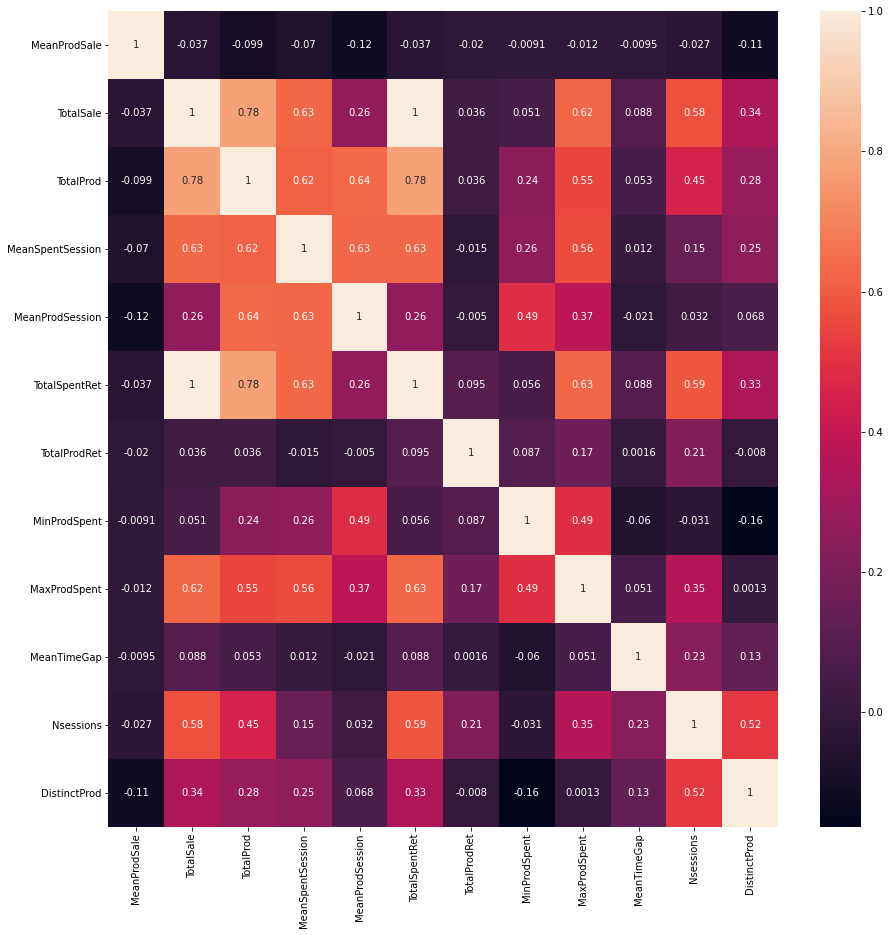

In [29]:
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sn.heatmap(df_09.corr(), annot=True)
plt.show()

In [30]:
corr_threshold = 0.8
print("Att. A\tAtt. B\tCorr(A,B)")
for i in range(0, len(df_09.columns)):
    for j in range(i+1, len(df_09.columns)):
        corr = df_09[df_09.columns[i]].corr(df_09[df_09.columns[j]])
        if  corr > corr_threshold:
            print(df_09.columns[i] + "\t" + df_09.columns[j] + "\t" + '{:.4f}'.format(corr))

Att. A	Att. B	Corr(A,B)
TotalSale	TotalSpentRet	0.9981


In [31]:
corr_columns = ['TotalSpentRet']
df_09.drop(corr_columns, axis=1, inplace=True)

<ipython-input-31-7b3f02996456>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_09.drop(corr_columns, axis=1, inplace=True)


In [26]:
#sn.pairplot(df_09, diag_kind='kde', height=1.5);

In [25]:
#log_customer_profile = pd.DataFrame({'MeanProdSale': np.log10(df_09['MeanProdSale']),
#                                     'TotalSale': np.log10(df_09['TotalSale']),
#                                     'TotalProd': np.log10(df_09['TotalProd']),
#                                     'MeanSpentSession': np.log10(df_09['MeanSpentSession']),
 #                                    'MeanProdSession': np.log10(df_09['MeanProdSession']),
  #                                   'TotalSpentRet': np.log10(df_09['TotalSpentRet']),
#                                  'TotalProdRet': np.log10(df_09['TotalProdRet']+1),
 #                                    'MinProdSpent': np.log10(df_09['MinProdSpent']),
  #                                   'MaxProdSpent': np.log10(df_09['MaxProdSpent']),
   #                                  'MeanTimeGap': np.log10(df_09['MeanTimeGap']+1),
    #                                 'Nsessions': np.log10(df_09['Nsessions']),
     #                                'DistinctProd': np.log10(df_09['DistinctProd'])
           #                         })
#log_customer_profile

In [34]:
df_09.to_csv(r'C:\Users\Stefano\Desktop\Data-Mining-Project\dataset\customer\new_Customer_2009.csv',header=True)